# Dynamic Parallel Execution with Map-Reduce using Send in LangGraph

---

## 🎯 Learning Objectives

By the end of this notebook, you will be able to:
1. **Understand the Map-Reduce pattern** in the context of LangGraph agentic systems
2. **Master the `Send` construct** for dynamic parallel execution
3. **Build a practical Map-Reduce workflow** that generates reports from parallel Q&A generation
4. **Handle dynamic state distribution** when the number of parallel tasks is not known at compile time

---

## 📚 Introduction to Map-Reduce in LangGraph

Map-reduce operations are essential for efficient task decomposition and parallel processing. This pattern is fundamental in distributed computing and is equally powerful in agentic AI systems.

### The Two Phases of Map-Reduce:

| Phase | Description | Example |
|-------|-------------|---------|
| **Map** | Break a task into smaller sub-tasks, processing each sub-task in parallel | Generate multiple questions, then answer each one in parallel |
| **Reduce** | Aggregate the results across all completed, parallelized sub-tasks | Combine all Q&A pairs into a comprehensive report |

---

## 🎯 What We Will Build

We will design a **Report Generation System** that demonstrates Map-Reduce:

1. **Map Phase**: 
   - Generate a set of questions about a given topic
   - Answer each question **in parallel** using `Send(...)`

2. **Reduce Phase**: 
   - Compile a comprehensive report based on all the Q&A pairs

---

## 🖼️ Architecture Diagram

![Map-Reduce Architecture](https://i.imgur.com/SN7KifO.png)

---

## 🔑 Why Use the Send Construct?

LangGraph's `Send` function is crucial when you need **dynamic parallelization**:

| Feature | Description |
|---------|-------------|
| **Task Decomposition** | Breaks down a large task into smaller, manageable sub-tasks |
| **Parallel Processing** | Executes sub-tasks concurrently, significantly reducing overall processing time |
| **Result Aggregation** | Combines outcomes from all sub-tasks to form a comprehensive response |
| **Dynamic Distribution** | Unlike static edges, `Send` allows runtime-determined parallelization |

### When to Use Send vs Static Edges?

- **Static Edges**: Use when you know the exact number of parallel branches at compile time (e.g., always 3 parallel paths)
- **Send Function**: Use when the number of parallel tasks is determined at runtime (e.g., variable number of questions generated)





---

## Step 1: Install Required Dependencies

First, we need to install the necessary packages:
- **langchain**: Core framework for building LLM applications
- **langchain-openai**: OpenAI integration for LangChain
- **langchain-community**: Community-contributed integrations
- **langgraph**: Framework for building stateful, multi-actor applications with LLMs

In [0]:
# ============================================================================
# INSTALLATION COMMANDS (Uncomment and run if packages are not installed)
# ============================================================================
# Note: Run these only once, then restart the kernel if needed

# !pip install langchain==0.3.14           # Core LangChain framework
# !pip install langchain-openai==0.3.0     # OpenAI models integration  
# !pip install langchain-community==0.3.14 # Community integrations
# !pip install langgraph==0.2.64           # LangGraph for building agent workflows

---

## Step 2: Configure API Credentials

We need to set up the OpenAI API key for accessing GPT models. Using `getpass` ensures your API key is not displayed in the notebook output.

In [0]:
# ============================================================================
# SECURE API KEY INPUT
# ============================================================================
# Import getpass for secure password/API key input
# This prevents the API key from being displayed in notebook output

# from getpass import getpass

# Securely prompt for the OpenAI API key
# The input will be masked for security
# OPENAI_KEY = getpass('Enter Open AI API Key: ')

### Set Environment Variables

Store the API key as an environment variable so LangChain can access it automatically.

In [0]:
# Set the API key as an environment variable
# LangChain automatically reads OPENAI_API_KEY from environment
# import os

# os.environ['OPENAI_API_KEY'] = OPENAI_KEY

# print("Environment variable set successfully!")

---

## Step 3: Define Agent State Schema

In LangGraph, the **State** is a central concept that holds all the data flowing through the graph. We need to define:

1. **Pydantic Models**: For structured output from the LLM (enforces schema validation)
2. **TypedDict State**: The overall state that flows through the graph

### Key Concept: The `Annotated` Type with `operator.add`

Notice the `Annotated[list, operator.add]` for `answers`. This is a **reducer function** that tells LangGraph how to combine multiple updates to the same field:
- When multiple `generate_answer` nodes run in parallel, each returns an answer
- The `operator.add` reducer **concatenates** all these answers into a single list
- This is essential for the Map-Reduce pattern!

In [1]:
# ============================================================================
# STATE SCHEMA DEFINITIONS
# ============================================================================
from typing_extensions import TypedDict
from pydantic import BaseModel
import operator
from typing import Annotated

# ----------------------------------------------------------------------------
# PYDANTIC MODELS FOR STRUCTURED LLM OUTPUT
# These models define the expected structure of LLM responses
# Using with_structured_output() ensures the LLM returns data in this format
# ----------------------------------------------------------------------------

class Questions(BaseModel):
    """
    Schema for the question generation node output.
    The LLM will return a list of questions about the given topic.
    """
    questions: list[str]  # List of sub-questions to explore

class Answer(BaseModel):
    """
    Schema for the answer generation node output.
    Each answer includes the original question for context.
    """
    question: str   # The question being answered
    answer: str     # The detailed answer

class Report(BaseModel):
    """
    Schema for the final report compilation.
    Contains the synthesized report text.
    """
    report: str     # The final comprehensive report

# ----------------------------------------------------------------------------
# OVERALL STATE FOR THE LANGGRAPH WORKFLOW
# This TypedDict defines all data that flows through the graph
# ----------------------------------------------------------------------------

class OverallState(TypedDict):
    """
    The main state object that persists throughout the graph execution.
    
    Attributes:
        topic: The input topic for report generation
        questions: List of generated sub-questions (Map phase input)
        answers: Accumulated answers from parallel execution (Map phase output)
                 Note: Uses Annotated[list, operator.add] as a REDUCER
                 This means when multiple nodes update 'answers', 
                 the values are concatenated (added) together!
        report: The final compiled report (Reduce phase output)
    """
    topic: str                              # Input: Topic to research
    questions: list                          # Generated questions (variable count)
    answers: Annotated[list, operator.add]   # KEY: Reducer function for parallel results!
    report: str                              # Output: Final compiled report

print("State schemas defined successfully!")

State schemas defined successfully!


---

## Step 4: Define Agent Node Functions

Now we define the nodes (functions) that will be executed in our graph. Each node performs a specific task in the Map-Reduce workflow.

### The Four Nodes in Our System:

| Node | Role | Phase |
|------|------|-------|
| `generate_questions` | Creates sub-questions about the topic | Planning |
| `continue_to_answers` | Routes each question to parallel processing using `Send` | Map (Distribution) |
| `generate_answer` | Answers a single question (runs in parallel) | Map (Execution) |
| `compile_report` | Combines all Q&A into a final report | Reduce |

### 🔑 Key Concept: The `Send` Function

The `Send` function is the **magic** that enables dynamic parallel execution:

```python
Send("node_name", {"state_key": "value"})
```

- **First argument**: Name of the target node to execute
- **Second argument**: State/data to pass to that node instance

When `continue_to_answers` returns a **list of `Send` objects**, LangGraph:
1. Creates a separate instance of `generate_answer` for each `Send`
2. Executes all instances **in parallel**
3. Collects all results and merges them using the reducer (`operator.add`)

### Why Send is Different from Static Edges:

| Static Edges | Send Function |
|-------------|---------------|
| Fixed number of parallel paths | Dynamic number of parallel paths |
| Defined at compile time | Determined at runtime |
| Good for known branching | Good for variable iteration |

In [2]:
# ============================================================================
# LLM SETUP: Initialize the Language Model
# ============================================================================
# We use helper functions to create LLM instances with proper configuration
# These functions handle API key loading and model configuration

import os
import sys

# Add parent directory to path for importing helpers
sys.path.append(os.path.abspath("../.."))

# Import our LLM factory functions
# Available options:
#   - get_groq_llm(): Creates a Groq-hosted LLM (fast inference, open-source models)
#   - get_openai_llm(): Creates an OpenAI GPT model
#   - get_databricks_llm(): Creates a Databricks-hosted LLM
from helpers.utils import get_groq_llm, get_openai_llm, get_databricks_llm

print("LLM helpers imported successfully!")

# ----------------------------------------------------------------------------
# Initialize the LLM
# Choose your preferred LLM provider by uncommenting the appropriate line
# ----------------------------------------------------------------------------

# Option 1: Databricks-hosted Claude (recommended for this demo)
llm = get_databricks_llm("databricks-claude-sonnet-4")

# Option 2: Groq for fast inference with open-source models
# llm = get_groq_llm()

# Option 3: OpenAI GPT models
# llm = get_openai_llm()

# Print confirmation of which LLM is being used
if hasattr(llm, 'model_name'):
    print(f"✅ LLM initialized: {llm.model_name}")
elif hasattr(llm, 'model'):
    print(f"✅ LLM initialized: {llm.model} (Databricks)")
else:
    print("✅ LLM initialized successfully")

/Users/sourav.banerjee/Documents/Codebases/2. AI ENGINEERING/Agents_with_LangGraph_Demystified/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


LLM helpers imported successfully!
✅ LLM initialized: databricks-claude-sonnet-4 (Databricks)


In [3]:
# ============================================================================
# NODE FUNCTION DEFINITIONS
# ============================================================================
# Each function represents a node in our LangGraph workflow.
# Nodes receive state as input and return state updates as output.

from langgraph.constants import Send  # Import the Send construct for dynamic parallel execution

# ============================================================================
# NODE 1: GENERATE QUESTIONS (Planning Phase)
# ============================================================================
# This node takes the input topic and generates a list of sub-questions.
# The number of questions can vary based on topic complexity.

def generate_questions(state: OverallState):
    """
    Generate sub-questions about the given topic.
    
    This is the PLANNING phase of our Map-Reduce workflow.
    The LLM analyzes the topic and generates relevant questions that,
    when answered, will provide comprehensive coverage of the topic.
    
    Args:
        state: Contains the 'topic' to research
        
    Returns:
        Dict with 'questions' list - these will be processed in parallel
    """
    # Prompt engineering: We instruct the LLM to generate a variable number
    # of questions based on topic complexity. This demonstrates how Send
    # handles dynamic parallelization.
    questions_prompt = """Generate a list of concise sub-questions related to this overall topic: {topic}
                          which would help build a good report.
                          Follow these rules for question generation:
                            - Do not create very long questions.
                            - Number of questions should always be 3 for simple topics (Birds, Animals, AI)
                              and 5 for more complex topics (Outlook for ..., Impact of ...)
                       """
    
    prompt = questions_prompt.format(topic=state["topic"])
    
    # Use structured output to ensure the LLM returns a valid Questions object
    response = llm.with_structured_output(Questions).invoke(prompt)
    
    print(f"📝 Generated {len(response.questions)} questions for topic: {state['topic']}")
    
    return {"questions": response.questions}


# ============================================================================
# NODE 2: GENERATE ANSWER (Map Phase - Execution)
# ============================================================================
# This node answers a SINGLE question. Multiple instances run in PARALLEL.

def generate_answer(state: Answer):
    """
    Generate an answer for a single question.
    
    This is the MAP EXECUTION phase. This function is called MULTIPLE TIMES
    in parallel - once for each question generated in the planning phase.
    
    IMPORTANT: Notice the state type is 'Answer', not 'OverallState'.
    This is because Send() passes a custom state to each parallel instance.
    
    Args:
        state: Contains just the 'question' to answer (passed via Send)
        
    Returns:
        Dict with 'answers' list - these get MERGED via operator.add reducer
    """
    answer_prompt = """Generate the answer about {question}."""
    prompt = answer_prompt.format(question=state["question"])
    
    # Get structured answer from LLM
    response = llm.with_structured_output(Answer).invoke(prompt)
    
    # IMPORTANT: Return as a LIST so the reducer (operator.add) can concatenate
    # all parallel results together!
    return {"answers": [{"question": state["question"], "answer": response.answer}]}


# ============================================================================
# NODE 3: CONTINUE TO ANSWERS (Map Phase - Distribution)
# ============================================================================
# This is a CONDITIONAL EDGE function that uses Send for parallel dispatch.

def continue_to_answers(state: OverallState):
    """
    Distribute questions to parallel answer generation using Send.
    
    This is the MAP DISTRIBUTION phase. It's the key function that enables
    dynamic parallel execution in LangGraph.
    
    HOW IT WORKS:
    1. Takes the list of questions from state
    2. Creates a Send object for EACH question
    3. Returns a LIST of Send objects
    4. LangGraph executes all Send targets IN PARALLEL
    
    Args:
        state: Contains 'questions' list from generate_questions
        
    Returns:
        List[Send] - Each Send creates a parallel instance of generate_answer
    """
    # 🔑 THE MAGIC: Create a Send for each question
    # Each Send("generate_answer", {...}) will:
    #   1. Create a new instance of the generate_answer node
    #   2. Pass the question in a custom state
    #   3. Execute in parallel with other Send instances
    
    sends = [Send("generate_answer", {"question": q}) for q in state["questions"]]
    
    print(f"🚀 Dispatching {len(sends)} parallel answer generation tasks...")
    
    return sends


# ============================================================================
# NODE 4: COMPILE REPORT (Reduce Phase)
# ============================================================================
# This node aggregates all parallel results into a final report.

def compile_report(state: OverallState):
    """
    Compile all Q&A pairs into a comprehensive report.
    
    This is the REDUCE phase. By the time this runs:
    - All parallel generate_answer calls have completed
    - All answers have been merged into state['answers'] via the reducer
    - We can now synthesize everything into a final report
    
    Args:
        state: Contains 'topic', 'questions', and all 'answers'
        
    Returns:
        Dict with 'report' - the final synthesized output
    """
    # Format all Q&A pairs for the prompt
    q_and_a = "\n\n".join(
        [f"Q: {qa['question']}\nA: {qa['answer']}" for qa in state["answers"]]
    )
    
    print(f"📊 Compiling report from {len(state['answers'])} Q&A pairs...")
    
    report_prompt = """Below are a bunch of questions and answers about topic:
                       {topic}.
                       Generate a detailed report from this about the topic.
                       {q_and_a}"""
    
    prompt = report_prompt.format(topic=state["topic"], q_and_a=q_and_a)
    
    response = llm.with_structured_output(Report).invoke(prompt)
    
    return {"report": response.report}


print("✅ All node functions defined successfully!")

✅ All node functions defined successfully!


/var/folders/b_/0hx_r16d2v712fg4k7y_rh140000gp/T/ipykernel_17788/3847278565.py:7: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send  # Import the Send construct for dynamic parallel execution


---

## Step 5: Build the LangGraph Workflow

Now we assemble our nodes into a complete graph. The key insight is how we connect the `generate_questions` node to parallel answer generation using **conditional edges**.

### Graph Structure:

```
START → generate_questions → [PARALLEL: generate_answer × N] → compile_report → END
```

### Key API Components:

| Component | Purpose |
|-----------|---------|
| `StateGraph(OverallState)` | Create a graph with our state schema |
| `add_node(name, fn)` | Register a node function |
| `add_edge(from, to)` | Create a direct edge between nodes |
| `add_conditional_edges(from, fn, targets)` | Create dynamic routing (used with Send) |
| `compile()` | Build the executable agent |

In [4]:
# ============================================================================
# BUILD THE LANGGRAPH WORKFLOW
# ============================================================================
from langgraph.graph import StateGraph, START, END

# ----------------------------------------------------------------------------
# Step 1: Create the StateGraph with our state schema
# The OverallState TypedDict defines all data that flows through the graph
# ----------------------------------------------------------------------------
graph = StateGraph(OverallState)

# ----------------------------------------------------------------------------
# Step 2: Add all nodes to the graph
# Each node is a function that processes state and returns updates
# ----------------------------------------------------------------------------
graph.add_node("generate_questions", generate_questions)  # Planning phase
graph.add_node("generate_answer", generate_answer)        # Map phase (parallel)
graph.add_node("compile_report", compile_report)          # Reduce phase

# ----------------------------------------------------------------------------
# Step 3: Define the edges (control flow)
# ----------------------------------------------------------------------------

# Edge 1: Start with question generation
graph.add_edge(START, "generate_questions")

# Edge 2: CONDITIONAL EDGE - The key to dynamic parallelization!
# The continue_to_answers function returns a list of Send objects,
# each targeting "generate_answer" with a different question.
# The third argument ["generate_answer"] tells LangGraph which nodes
# might be targeted by the conditional function.
graph.add_conditional_edges(
    "generate_questions",      # From this node...
    continue_to_answers,       # ...run this function to decide next steps
    ["generate_answer"]        # ...which may route to these nodes
)

# Edge 3: After all parallel answer generations complete, compile the report
# This edge is triggered once ALL Send targets have completed
graph.add_edge("generate_answer", "compile_report")

# Edge 4: End after report compilation
graph.add_edge("compile_report", END)

# ----------------------------------------------------------------------------
# Step 4: Compile the graph into an executable agent
# ----------------------------------------------------------------------------
agent = graph.compile()

print("✅ Agent graph compiled successfully!")

✅ Agent graph compiled successfully!


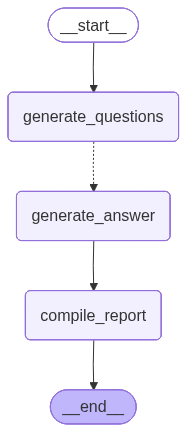

In [5]:
# ============================================================================
# VISUALIZE THE GRAPH STRUCTURE
# ============================================================================
# LangGraph provides built-in visualization using Mermaid diagrams.
# This helps understand the workflow structure at a glance.
#
# In the visualization, you'll see:
#   - START → generate_questions: Entry point
#   - generate_questions → generate_answer: Conditional edge (Send-based)
#   - generate_answer → compile_report: Aggregation point
#   - compile_report → END: Final output

from IPython.display import display, Image

# Render the graph as a PNG image using Mermaid
Image(agent.get_graph().draw_mermaid_png())

---

## Step 6: Run and Test the Agent

Let's test our Map-Reduce agent with different topics to see how it handles:
1. **Simple topics** → Generates fewer questions (3)
2. **Complex topics** → Generates more questions (5)

### Understanding the Output:

When we stream the agent execution, we see state updates at each step:
1. `generate_questions`: Shows the list of generated questions
2. `generate_answer`: Shows each Q&A pair (may appear in parallel)
3. `compile_report`: Shows the final synthesized report

### Test Cases:

| Topic | Expected Complexity | Expected Questions |
|-------|--------------------|--------------------|
| "Artificial Intelligence" | Simple | ~3 questions |
| "Animals" | Simple | ~3 questions |
| "Impact of AI on jobs" | Complex | ~5 questions |

In [6]:
# ============================================================================
# TEST 1: Simple Topic - "Artificial Intelligence"
# ============================================================================
# Expected behavior:
#   - generate_questions creates ~3 sub-questions
#   - Each question is answered in parallel via Send
#   - All answers are aggregated and compiled into a report

from IPython.display import display, Markdown

print("=" * 70)
print("🧪 TEST 1: Simple Topic - Artificial Intelligence")
print("=" * 70)

# Stream the agent execution to observe each step
# The stream yields state updates after each node completes
for state in agent.stream({"topic": "Artificial Intelligence"}):
    print(state)
    print("-" * 50)
    
    # Display the final report in formatted Markdown
    if 'compile_report' in state:
        print("\n📋 FINAL REPORT:")
        display(Markdown(state['compile_report']['report']))

🧪 TEST 1: Simple Topic - Artificial Intelligence
📝 Generated 3 questions for topic: Artificial Intelligence
🚀 Dispatching 3 parallel answer generation tasks...
{'generate_questions': {'questions': ['What is artificial intelligence and how does it work?', 'What are the main applications and benefits of AI in different industries?', 'What are the potential risks and ethical concerns associated with AI development?']}}
--------------------------------------------------
{'generate_answer': {'answers': [{'question': 'What is artificial intelligence and how does it work?', 'answer': 'Artificial Intelligence (AI) is a branch of computer science that aims to create machines and systems capable of performing tasks that typically require human intelligence. These tasks include learning, reasoning, problem-solving, perception, language understanding, and decision-making.\n\n**What AI is:**\nAI encompasses various technologies and approaches designed to simulate human cognitive functions. It range

# Comprehensive Report on Artificial Intelligence

## Executive Summary

Artificial Intelligence (AI) represents one of the most transformative technological developments of the 21st century. This report examines the fundamental nature of AI, its widespread applications across industries, and the critical risks and ethical considerations that accompany its rapid advancement. As AI continues to evolve from narrow, task-specific systems toward more sophisticated general intelligence, understanding its mechanisms, benefits, and challenges becomes increasingly vital for individuals, organizations, and society as a whole.

## Understanding Artificial Intelligence

### Definition and Core Concepts

Artificial Intelligence is a branch of computer science dedicated to creating machines and systems capable of performing tasks that traditionally require human intelligence. These capabilities encompass learning, reasoning, problem-solving, perception, language understanding, and decision-making. AI represents a spectrum of technologies ranging from simple rule-based systems to complex neural networks that can recognize patterns, make predictions, and adapt to new information.

### How AI Functions

The operational framework of AI relies on several interconnected components:

**Data Processing**: AI systems excel at analyzing vast quantities of data to identify patterns, relationships, and trends that may be imperceptible to human analysis. This capability forms the foundation for AI's decision-making processes.

**Machine Learning**: This core component enables algorithms to learn from data without explicit programming for every scenario. The system continuously improves its performance as it processes additional data, creating a self-improving cycle of enhancement.

**Neural Networks**: Inspired by the structure of the human brain, these interconnected nodes process information through multiple layers, with each layer extracting increasingly sophisticated features from input data.

**Algorithmic Foundation**: Mathematical procedures and rules guide how AI processes information, makes decisions, and generates outputs, providing the logical framework for intelligent behavior.

**Training and Validation**: AI systems undergo extensive training on datasets to learn patterns and relationships, followed by testing phases to ensure they can generalize effectively to new, previously unseen data.

### Types of AI Systems

The AI landscape encompasses several distinct categories:

- **Narrow AI**: Designed for specific tasks such as voice assistants, recommendation systems, or image recognition
- **General AI**: A theoretical form of AI with human-level intelligence across all cognitive domains
- **Machine Learning**: Systems that improve performance through experience and data exposure
- **Deep Learning**: Advanced neural networks with multiple layers capable of processing complex, hierarchical data structures

## Industry Applications and Benefits

### Healthcare Transformation

AI has revolutionized healthcare through applications including medical imaging analysis, drug discovery acceleration, personalized treatment planning, robotic surgery assistance, and virtual health assistants. The benefits are substantial: improved diagnostic accuracy, accelerated treatment decisions, reduced medical errors, significant cost reductions, and enhanced patient outcomes. AI's ability to process vast amounts of medical data enables healthcare providers to deliver more precise, personalized care while reducing the burden on medical professionals.

### Financial Services Innovation

The financial sector has embraced AI for fraud detection, algorithmic trading, credit scoring, robo-advisory services, and regulatory compliance. These applications deliver enhanced security measures, faster transaction processing, improved risk assessment capabilities, personalized financial services, and reduced operational costs. AI's pattern recognition capabilities are particularly valuable in identifying fraudulent activities and optimizing investment strategies.

### Manufacturing Excellence

Manufacturing industries leverage AI for predictive maintenance, quality control, supply chain optimization, robotic automation, and demand forecasting. The resulting benefits include reduced equipment downtime, improved product quality, increased operational efficiency, substantial cost savings, and enhanced workplace safety. AI enables manufacturers to transition from reactive to predictive maintenance models, significantly improving productivity.

### Retail and E-commerce Enhancement

AI powers recommendation systems, inventory management, price optimization, customer service chatbots, and visual search capabilities in retail environments. These applications create personalized customer experiences, increase sales conversion rates, optimize inventory levels, and improve customer service quality. The ability to analyze consumer behavior patterns enables retailers to anticipate demand and customize offerings.

### Transportation Revolution

The transportation sector utilizes AI for autonomous vehicle development, route optimization, traffic management, predictive maintenance, and logistics planning. Benefits include enhanced safety through reduced human error, decreased fuel consumption, improved operational efficiency, and lower transportation costs. AI is fundamental to the development of smart transportation systems and autonomous vehicle technology.

### Agricultural Advancement

AI applications in agriculture include precision farming, crop monitoring, pest detection, yield prediction, and automated harvesting systems. These technologies increase crop yields, reduce resource waste, promote sustainable farming practices, and optimize operational costs. AI enables farmers to make data-driven decisions that improve both productivity and environmental sustainability.

### Educational Innovation

Educational applications encompass personalized learning systems, automated grading, intelligent tutoring systems, and student performance analytics. The benefits include customized learning experiences tailored to individual needs, improved educational outcomes, reduced teacher workload, and enhanced accessibility for diverse learning populations.

### Energy Sector Optimization

AI contributes to smart grid management, renewable energy optimization, predictive maintenance of energy infrastructure, and energy consumption forecasting. These applications improve energy efficiency, reduce operational costs, enhance grid stability, and enable better resource allocation across energy networks.

## Risks and Ethical Considerations

### Technical and Safety Challenges

The development of AI systems presents several critical technical risks. The alignment problem represents a fundamental challenge in ensuring AI systems pursue intended goals without causing unintended harm. As AI systems become increasingly complex, their behavior may become unpredictable, potentially leading to outcomes that diverge from human expectations. Security vulnerabilities expose AI systems to hacking, manipulation, and malicious use. Perhaps most concerning is the potential existential risk posed by advanced AI systems that could threaten human survival if not properly controlled and aligned with human values.

### Bias and Fairness Issues

AI systems can perpetuate and amplify existing societal biases related to race, gender, age, and socioeconomic status. These algorithmic biases can result in discriminatory outcomes in critical areas such as hiring practices, lending decisions, criminal justice proceedings, and healthcare delivery. Training data that inadequately represents all populations exacerbates these representation gaps, leading to AI systems that perform poorly for underrepresented groups.

### Privacy and Surveillance Concerns

The data-intensive nature of AI systems raises significant privacy concerns. AI applications often require vast amounts of personal data, potentially enabling unprecedented surveillance and tracking capabilities. The development of surveillance states becomes possible when AI technologies are deployed without appropriate privacy safeguards. Users frequently have limited understanding or control over how their personal data is collected, processed, and utilized by AI systems.

### Economic and Social Impact

AI-driven automation may eliminate jobs faster than new employment opportunities are created, leading to significant job displacement across various sectors. The economic benefits of AI may become concentrated among technology owners, potentially exacerbating economic inequality. Rapid technological changes may destabilize communities and existing social structures, requiring careful management of the transition to an AI-integrated society.

### Autonomy and Human Agency

Over-reliance on AI systems for decision-making may diminish human autonomy and critical thinking capabilities. Important human skills and knowledge may atrophy from disuse as AI systems assume greater responsibility for tasks previously performed by humans. AI systems could potentially be used to manipulate human behavior and decision-making processes, raising concerns about free will and authentic choice.

### Accountability and Transparency

Many AI systems operate as "black boxes," making their decision-making processes difficult to interpret or explain. This opacity creates a responsibility gap where it becomes unclear who should be held accountable when AI systems cause harm. The rapid pace of AI development challenges traditional democratic governance structures, making it difficult to regulate and oversee AI development effectively.

### Dual-Use Concerns

AI technologies present dual-use challenges, as they can be applied for both beneficial and harmful purposes. Military applications include the development of autonomous weapons systems that could fundamentally change the nature of warfare. AI tools can be exploited for cyberattacks, disinformation campaigns, and other malicious activities that threaten social stability and security.

## Conclusion and Future Considerations

Artificial Intelligence represents both tremendous opportunity and significant challenge for humanity. Its applications across industries demonstrate the potential to increase efficiency, reduce costs, improve decision-making, and create new opportunities that can benefit society broadly. However, the risks and ethical concerns associated with AI development require proactive, thoughtful approaches to ensure that AI systems are developed and deployed responsibly.

The path forward requires ongoing collaboration between technologists, ethicists, policymakers, and society to develop appropriate safeguards, regulations, and ethical frameworks. This collaborative approach must balance innovation with responsibility, ensuring that AI development serves human interests while mitigating potential harms.

As AI continues to evolve toward more sophisticated forms of artificial general intelligence, the importance of addressing these challenges becomes increasingly critical. The decisions made today regarding AI development, regulation, and deployment will significantly influence the trajectory of human civilization and the role that artificial intelligence plays in shaping our collective future.

Success in navigating the AI revolution will require sustained commitment to ethical development practices, robust governance frameworks, and inclusive approaches that consider the needs and concerns of all stakeholders. Only through such comprehensive efforts can society harness the transformative potential of AI while safeguarding human values, rights, and well-being.

In [7]:
# ============================================================================
# TEST 2: Simple Topic - "Animals"
# ============================================================================
# Another simple topic to verify consistent behavior with few questions

print("\n" + "=" * 70)
print("🧪 TEST 2: Simple Topic - Animals")
print("=" * 70)

for state in agent.stream({"topic": "Animals"}):
    print(state)
    print("-" * 50)
    
    if 'compile_report' in state:
        print("\n📋 FINAL REPORT:")
        display(Markdown(state['compile_report']['report']))


🧪 TEST 2: Simple Topic - Animals
📝 Generated 3 questions for topic: Animals
🚀 Dispatching 3 parallel answer generation tasks...
{'generate_questions': {'questions': ['What are the main classifications of animals?', 'How do animals adapt to their environments?', 'What role do animals play in ecosystems?']}}
--------------------------------------------------
{'generate_answer': {'answers': [{'question': 'How do animals adapt to their environments?', 'answer': "Animals adapt to their environments through various mechanisms that help them survive and reproduce in their specific habitats. Here are the key ways animals adapt:\n\n**Physical Adaptations (Structural):**\n- Body shape and size modifications (e.g., streamlined bodies in fish for swimming)\n- Specialized body parts (e.g., long necks in giraffes for reaching high leaves)\n- Protective features (e.g., thick fur in arctic animals, shells in turtles)\n- Camouflage and coloration (e.g., chameleons changing colors, polar bears' white f

# Comprehensive Report on Animals

## Introduction

Animals represent one of the most diverse and complex kingdoms of life on Earth, encompassing millions of species that have evolved remarkable adaptations to survive in virtually every environment on the planet. This report examines the fundamental aspects of animal life, including their classification systems, adaptive mechanisms, and critical ecological roles.

## Animal Classification Systems

### Hierarchical Taxonomic Organization

The scientific classification of animals follows a well-established hierarchical system that organizes species based on evolutionary relationships and shared characteristics. This system progresses from broad to specific categories:

1. **Kingdom Animalia** - encompasses all animal life
2. **Phylum** - groups animals by major body plan similarities
3. **Class** - further subdivides phyla based on specific characteristics
4. **Order** - organizes animals with similar behavioral and structural traits
5. **Family** - groups closely related organisms
6. **Genus** - contains very similar species
7. **Species** - represents distinct, interbreeding populations

### Major Animal Phyla

The animal kingdom is divided into several major phyla, each representing fundamentally different body plans and evolutionary lineages:

- **Chordata**: Vertebrate animals including mammals, birds, fish, reptiles, and amphibians, characterized by the presence of a backbone
- **Arthropoda**: The largest phylum, including insects, spiders, and crustaceans, distinguished by jointed legs and segmented bodies
- **Mollusca**: Soft-bodied animals such as snails, clams, and octopuses, often protected by shells
- **Cnidaria**: Aquatic animals like jellyfish and corals that possess specialized stinging cells
- **Porifera**: Simple, filter-feeding sponges
- **Echinodermata**: Marine animals including starfish and sea urchins with spiny skin and radial symmetry
- **Platyhelminthes**: Flatworms with simple body structures
- **Nematoda**: Roundworms found in diverse environments
- **Annelida**: Segmented worms including earthworms and marine polychaetes

### Alternative Classification Methods

Beyond taxonomic classification, animals can be categorized by various functional and ecological criteria:
- Vertebrates versus invertebrates (presence or absence of backbone)
- Thermoregulation strategies (warm-blooded versus cold-blooded)
- Habitat preferences (terrestrial, aquatic, or aerial)
- Feeding behaviors (herbivores, carnivores, omnivores)

## Animal Adaptations to Environmental Challenges

### Physical Adaptations

Animals have evolved remarkable structural modifications to thrive in their specific environments:

- **Body morphology**: Streamlined shapes in aquatic animals for efficient swimming, elongated necks in giraffes for accessing high vegetation
- **Protective structures**: Thick fur in arctic species for insulation, defensive shells in turtles and mollusks
- **Camouflage mechanisms**: Color-changing abilities in chameleons, seasonal coat changes in arctic foxes

### Behavioral Adaptations

Animal behaviors have evolved to maximize survival and reproductive success:

- **Migration patterns**: Seasonal movements to exploit resources and avoid harsh conditions
- **Dormancy strategies**: Hibernation and estivation to survive resource-scarce periods
- **Social behaviors**: Cooperative hunting in wolves, flocking in birds for protection and navigation
- **Construction activities**: Nest-building and shelter creation for protection and reproduction

### Physiological Adaptations

Internal biological processes have been fine-tuned for specific environmental demands:

- **Water conservation**: Highly efficient kidneys in desert animals
- **Sensory enhancements**: Echolocation in bats and marine mammals for navigation and hunting
- **Digestive specializations**: Multi-chambered stomachs in ruminants for processing plant material
- **Metabolic adjustments**: Altered metabolic rates for different activity levels and environmental conditions

### Evolutionary Mechanisms

These adaptations arise through natural selection over multiple generations, where individuals with advantageous traits have higher survival and reproductive rates, gradually spreading beneficial characteristics throughout populations.

## Ecological Roles and Ecosystem Functions

### Energy Flow and Trophic Relationships

Animals serve as critical components in ecosystem energy transfer:
- Primary consumers convert plant energy into animal biomass
- Secondary and tertiary consumers regulate herbivore populations
- Decomposer animals recycle nutrients from dead organic matter
- These relationships create complex food webs that maintain ecosystem stability

### Pollination Services

Many animals provide essential pollination services that support plant reproduction:
- Bees, butterflies, and other insects pollinate the majority of flowering plants
- Birds and bats serve as pollinators for specific plant species
- These relationships are crucial for both natural ecosystems and agricultural productivity

### Seed Dispersal Networks

Animals facilitate plant distribution and genetic diversity through seed dispersal:
- Fruit-eating animals transport seeds to new locations through their digestive systems
- This process enables plant colonization of new habitats and maintains genetic flow between plant populations

### Nutrient Cycling

Animal activities contribute significantly to nutrient distribution and cycling:
- Animal waste products fertilize soils and provide essential nutrients for plant growth
- Decomposer animals break down organic matter, returning nutrients to the ecosystem
- These processes maintain soil fertility and support primary productivity

### Population Regulation

Predator-prey relationships provide natural population control mechanisms:
- Predators prevent herbivore overgrazing that could damage plant communities
- These interactions maintain species diversity and prevent ecological dominance by single species

### Habitat Engineering

Many animals actively modify their environments, creating opportunities for other species:
- Beavers construct wetland habitats through dam building
- Burrowing animals improve soil structure and create microhabitats
- Coral animals build reef structures that support diverse marine communities

## Conclusion

Animals represent a fundamental component of Earth's biodiversity, exhibiting remarkable diversity in form, function, and ecological roles. Their sophisticated classification systems reflect millions of years of evolutionary divergence, while their varied adaptations demonstrate the power of natural selection in shaping life to meet environmental challenges. Perhaps most importantly, animals serve as keystone components in ecosystem functioning, providing services essential for maintaining ecological balance and supporting all life on Earth. Understanding these aspects of animal biology is crucial for conservation efforts and maintaining the health of our planet's ecosystems.

In [8]:
# ============================================================================
# TEST 3: Complex Topic - "Impact of AI on jobs"
# ============================================================================
# A more complex topic should generate more questions (~5),
# demonstrating how Send handles variable parallelization

print("\n" + "=" * 70)
print("🧪 TEST 3: Complex Topic - Impact of AI on jobs")
print("=" * 70)
print("Note: Expect more questions for this complex topic!\n")

for state in agent.stream({"topic": "Impact of AI on jobs"}):
    print(state)
    print("-" * 50)
    
    if 'compile_report' in state:
        print("\n📋 FINAL REPORT:")
        display(Markdown(state['compile_report']['report']))


🧪 TEST 3: Complex Topic - Impact of AI on jobs
Note: Expect more questions for this complex topic!

📝 Generated 5 questions for topic: Impact of AI on jobs
🚀 Dispatching 5 parallel answer generation tasks...
{'generate_questions': {'questions': ['Which job sectors are most vulnerable to AI automation?', 'What new job categories are emerging due to AI advancement?', 'How can workers adapt and reskill for an AI-driven economy?', 'What are the economic implications of widespread job displacement by AI?', "How do different countries' policies address AI's impact on employment?"]}}
--------------------------------------------------
{'generate_answer': {'answers': [{'question': 'What new job categories are emerging due to AI advancement?', 'answer': 'AI advancement is creating numerous new job categories across various industries. Here are the key emerging roles:\n\n**AI Development & Engineering:**\n- AI/Machine Learning Engineers\n- AI Research Scientists\n- Computer Vision Engineers\n- N

# The Impact of AI on Jobs: A Comprehensive Analysis

## Executive Summary

The integration of artificial intelligence (AI) into the global economy represents one of the most significant technological shifts in modern history, fundamentally reshaping the employment landscape. This report examines the multifaceted impact of AI on jobs, analyzing vulnerable sectors, emerging opportunities, adaptation strategies, economic implications, and policy responses across different nations.

## Sectors Most Vulnerable to AI Automation

The current wave of AI automation poses the greatest threat to jobs characterized by routine, predictable tasks and rule-based decision-making. The most vulnerable sectors include:

**Manufacturing and Production** leads the list, where routine assembly line work, quality control, and repetitive manufacturing tasks are already being replaced by robotics and AI systems. The predictable nature of these roles makes them ideal candidates for automation.

**Transportation and Logistics** faces significant disruption from autonomous vehicles and robotic systems, threatening traditional truck driving, delivery services, and warehouse operations. The development of self-driving technology and automated sorting systems continues to advance rapidly in this sector.

**Retail and Customer Service** is experiencing widespread automation through self-checkout systems, AI-powered chatbots, and automated inventory management, displacing cashiers and basic customer support roles.

**Data Entry and Administrative Support** roles are particularly vulnerable due to AI's superior efficiency in handling clerical work, basic bookkeeping, and routine administrative tasks that follow established patterns.

**Food Service** operations, especially in fast food, face automation through robotic preparation systems and AI-powered ordering platforms, affecting order-taking and basic food preparation roles.

**Banking and Finance** sectors see routine tasks like basic financial analysis, loan processing, and standard banking operations increasingly automated, though complex advisory roles remain more secure.

The vulnerability of these sectors stems from common factors: high task repetition, predictable workflows, rule-based decision-making processes, and limited requirements for creativity or emotional intelligence.

## Emerging Job Categories and Opportunities

Despite widespread displacement concerns, AI advancement is simultaneously creating numerous new employment categories across various industries:

**AI Development and Engineering** represents the most direct job creation, including roles such as AI/Machine Learning Engineers, AI Research Scientists, Computer Vision Engineers, and Natural Language Processing Specialists. These positions require deep technical expertise and are experiencing rapid growth.

**AI Ethics and Governance** has emerged as a critical field, creating positions for AI Ethics Officers, Algorithm Auditors, AI Policy Specialists, and Bias Detection Specialists. These roles address growing concerns about responsible AI deployment and regulatory compliance.

**Data and Analytics** specialization continues expanding with AI-focused Data Scientists, AI Data Architects, Prompt Engineers, and MLOps Engineers becoming increasingly valuable as organizations seek to leverage AI capabilities effectively.

**Human-AI Interaction** design represents a new frontier, requiring specialists who can create seamless interfaces between humans and AI systems, including Conversational AI Designers and AI User Experience Specialists.

**AI Implementation and Support** roles bridge the gap between AI development and practical application, including AI Integration Specialists, Solutions Architects, and Customer Success Managers who help organizations adopt and optimize AI technologies.

Industry-specific AI roles are proliferating across healthcare, finance, legal services, marketing, and cybersecurity, creating hybrid positions that combine domain expertise with AI knowledge.

## Worker Adaptation and Reskilling Strategies

Successfully navigating the AI-driven economy requires workers to adopt comprehensive adaptation strategies:

**Developing Human-Centric Skills** remains paramount, as emotional intelligence, creativity, critical thinking, and interpersonal communication represent areas where humans maintain significant advantages over AI systems. These skills become increasingly valuable as AI handles more routine tasks.

**Embracing Lifelong Learning** has become essential rather than optional. Workers must cultivate continuous learning mindsets, leveraging online courses, certifications, micro-credentials, and professional development programs to stay relevant in rapidly evolving job markets.

**Building AI Literacy** enables workers to collaborate effectively with AI tools rather than compete against them. Understanding AI capabilities, limitations, and applications within specific industries allows workers to position themselves as valuable human-AI collaborators.

**Pursuing Hybrid Skills** that combine technical knowledge with domain expertise creates unique value propositions. Workers who can bridge technology and human needs, combining analytical and creative thinking, often find themselves in high demand.

**Targeting Growth Areas** requires strategic career planning toward industries and roles expanding due to AI, including healthcare, cybersecurity, AI ethics, and newly created job categories that emerge from technological advancement.

**Building Adaptability** through resilience, flexibility, active networking, and staying informed about industry trends enables workers to navigate career transitions more successfully.

## Economic Implications of AI-Driven Job Displacement

The economic consequences of widespread AI adoption present both significant challenges and potential opportunities:

**Negative Economic Effects** include increased unemployment and underemployment, particularly affecting middle-skill jobs in manufacturing, transportation, and customer service. This displacement could exacerbate income inequality as high-skill workers who complement AI see wage increases while displaced workers face income loss. Reduced consumer spending power from unemployed workers could trigger economic downturns, while increased demand for social services strains safety nets. Regional economies heavily dependent on automation-susceptible industries face particular disruption.

**Potential Positive Economic Effects** include increased productivity and efficiency leading to lower production costs and consumer prices. AI advancement could drive economic growth through new industries and services, enable capital reallocation to more innovative sectors, and enhance business and national competitiveness.

**Transition Challenges** encompass skills mismatches between displaced workers' abilities and new job requirements, significant retraining costs and time investments, generational disparities in technological adaptation, and potential political and social instability if economic benefits aren't broadly shared.

The ultimate economic impact depends heavily on policy interventions, education system adaptations, and social support mechanisms implemented during this transition period.

## Global Policy Responses and Approaches

Different countries are implementing varied strategies to address AI's employment impact, reflecting diverse economic contexts and policy priorities:

**The United States** emphasizes market-driven solutions with minimal direct intervention, focusing on retraining programs through public-private partnerships and tax incentives for companies investing in worker development. The National AI Initiative includes workforce development components, though social safety net expansion remains limited compared to other developed nations.

**The European Union** takes a comprehensive approach through the EU AI Act and Digital Single Market strategy, emphasizing strong worker protection and rights. Significant investment in reskilling programs through the European Skills Agenda, exploration of algorithmic management regulations, and consideration of universal basic income pilots in some member states demonstrate the EU's proactive stance.

**China** implements a state-led approach with massive investment in AI education and training, integrating AI workforce planning into national economic plans. The focus centers on creating new AI-related job categories and emphasizing technical education and STEM skills development, with less emphasis on social safety nets and more on job creation.

**Nordic Countries** (Sweden, Denmark, Finland) employ proactive "flexicurity" models combining job flexibility with strong social protection. Extensive adult education and lifelong learning programs, universal basic income experiments, strong labor union involvement in AI transition planning, and high investment in digital infrastructure characterize their approach.

**Singapore** demonstrates targeted intervention through the SkillsFuture initiative providing learning credits, industry-specific transformation programs, close government-employer-union collaboration, and focused efforts to become an AI hub while managing workforce transitions.

**Canada** implements the Pan-Canadian Artificial Intelligence Strategy with workforce components, federal funding for AI research and training programs, and focus on ethical AI development with employment considerations, though implementation varies by province.

## Key Policy Trends and Recommendations

Several common trends emerge across successful policy approaches:

1. **Reskilling and Upskilling** programs receive priority across most countries, recognizing education and training as fundamental to successful transitions.

2. **Social Safety Net** approaches vary from universal basic income experiments to enhanced unemployment benefits, reflecting different philosophical approaches to supporting displaced workers.

3. **Regulatory Frameworks** attempt to balance innovation promotion with worker protection, though approaches differ significantly.

4. **Public-Private Partnerships** facilitate collaboration between government, industry, and educational institutions to address skills gaps and transition challenges.

5. **Sector-Specific Approaches** tailor policies for manufacturing, services, and knowledge work, recognizing that different industries face unique challenges and opportunities.

## Conclusion

The impact of AI on jobs represents a complex transformation requiring coordinated responses from individuals, organizations, and governments. While certain sectors face significant displacement risks, new opportunities are simultaneously emerging across various fields. Success in navigating this transition depends on proactive adaptation strategies, comprehensive reskilling efforts, and thoughtful policy interventions that ensure the benefits of AI advancement are broadly shared while supporting those most affected by displacement.

The countries and individuals who successfully adapt to this AI-driven economy will likely be those who embrace lifelong learning, develop human-AI collaboration skills, and implement policies that balance innovation with social protection. As this transformation continues to unfold, ongoing monitoring, evaluation, and adjustment of strategies will be essential to maximize benefits while minimizing negative consequences for workers and society as a whole.

## 🎓 Summary and Key Takeaways

Congratulations! You've learned how to implement the **Map-Reduce pattern** in LangGraph using the **Send construct** for dynamic parallel execution.

### Key Concepts Covered:

| Concept | Description |
|---------|-------------|
| **Map-Reduce Pattern** | Decompose tasks → Process in parallel → Aggregate results |
| **Send Construct** | `Send("node_name", state)` - Dynamically dispatch to parallel nodes |
| **State Reducers** | `Annotated[list, operator.add]` - Merge parallel results automatically |
| **Conditional Edges** | Route dynamically based on runtime conditions |

### When to Use This Pattern:

✅ **Good Use Cases:**
- Report generation from multiple sub-queries
- Research assistants that explore topics from multiple angles
- Data processing with variable number of items
- Any workflow where parallelization count is runtime-determined

❌ **Avoid When:**
- Fixed number of parallel tasks (use static edges instead)
- Sequential dependencies between tasks
- Simple single-step operations

### Architecture Recap:

```
┌─────────────┐     ┌─────────────────┐     ┌─────────────────┐     ┌─────────────────┐
│    START    │────▶│   generate_     │────▶│ continue_to_    │────▶│   generate_     │
│             │     │   questions     │     │   answers       │     │   answer (×N)   │
└─────────────┘     └─────────────────┘     └─────────────────┘     └────────┬────────┘
                                                   │                         │
                                                   │                         │ (parallel)
                                                   │                         │
                                            ┌──────▼─────────────────────────▼──────┐
                                            │              compile_report           │
                                            └──────────────────┬────────────────────┘
                                                               │
                                                               ▼
                                                          ┌─────────┐
                                                          │   END   │
                                                          └─────────┘
```

### Next Steps:

1. **Experiment**: Try different topics and observe the variable question counts
2. **Extend**: Add error handling for failed LLM calls
3. **Optimize**: Implement caching for repeated questions
4. **Scale**: Apply this pattern to more complex multi-stage workflows

---

## 📚 Additional Resources

- [LangGraph Documentation](https://python.langchain.com/docs/langgraph)
- [Send API Reference](https://langchain-ai.github.io/langgraph/reference/graphs/)
- [Map-Reduce Patterns in Distributed Systems](https://en.wikipedia.org/wiki/MapReduce)